In [52]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing import image
from keras.engine.topology import Input
from keras.models import Model, load_model
from keras.applications.xception import preprocess_input

from vis.utils import utils
from keras import activations
from vis.visualization import visualize_saliency


In [25]:
IMG_SIZE = 299
img_shape = (IMG_SIZE, IMG_SIZE, 3)

# EPOCHS = 50
# BATCH_SIZE = 16
# NUM_CLASSES = 76


In [83]:
model = load_model('/Users/yueying.teng/Documents/indoor_gps/models/2018-12-19_fulldata_gps_xception_model_0.01_midway.h5')
# model.summary()


In [48]:
classes = []
for i in np.random.randint(76, size = 5):
    classes.append('{:04d}'.format(i + 1))
    

In [56]:
img_path = []

for i in classes:
    class_dir = '/Users/yueying.teng/Documents/indoor_gps/data/test/class_' + i
    img = random.choice(os.listdir(class_dir))
    img_dir = os.path.join(class_dir, img)
    img_path.append(img_dir)
    

In [58]:
def load_img(img_dir):
    img_img = image.load_img(img_dir, target_size = (IMG_SIZE, IMG_SIZE))
    img = image.img_to_array(img_img)
    img_processed = preprocess_input(img)

    return img_processed


In [64]:
pred_label = []

for i in img_path:
    img_processed = load_img(i)
    predictions = model.predict(img_processed[np.newaxis, :])
    pred_label.append(np.argmax(predictions[0]) + 1)
    

In [84]:

# Utility to search for layer index by name.
layer_idx = utils.find_layer_idx(model, 'dense_4')
print(layer_idx)

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)


137


### saliency map

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


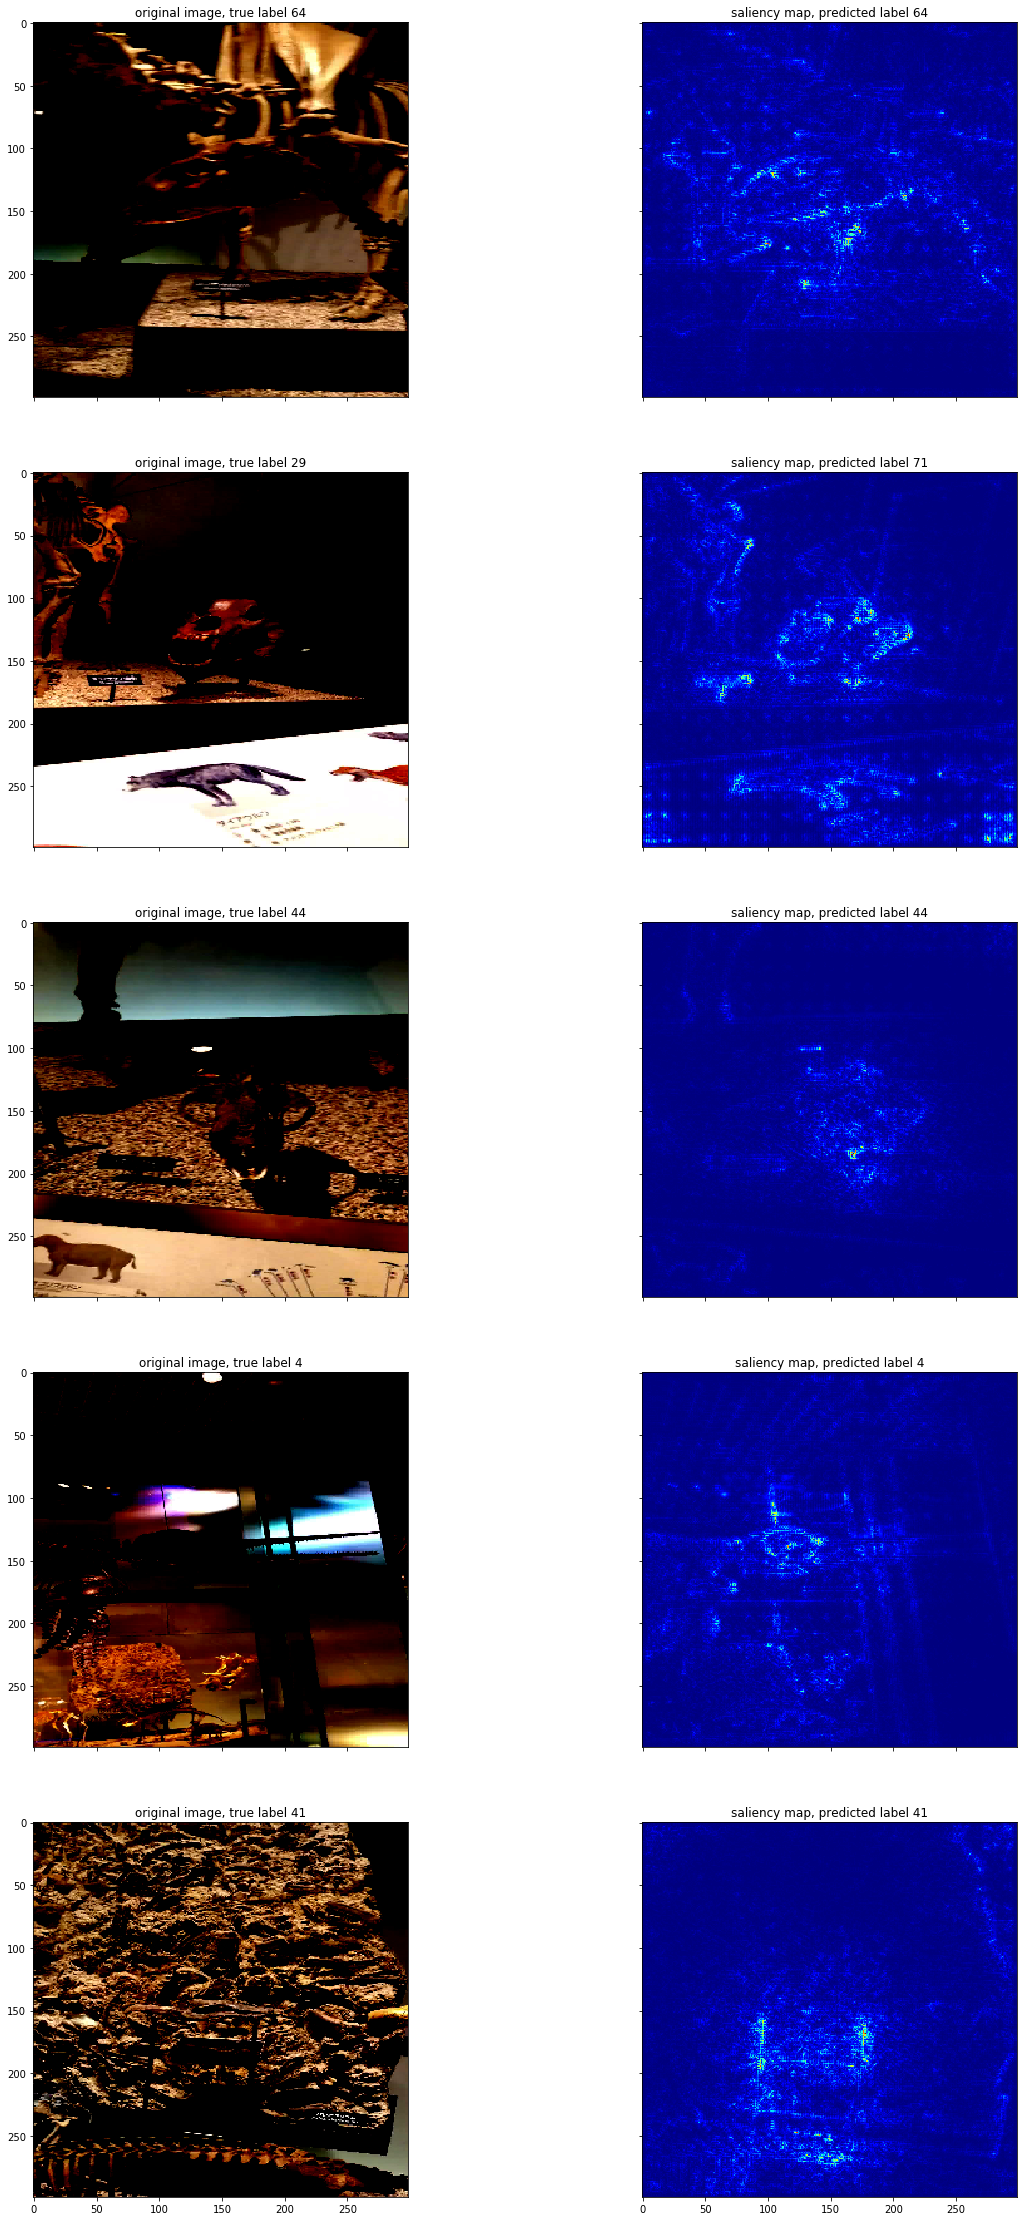

In [100]:
fig, ax = plt.subplots(5, 2, sharex='col', sharey='row', figsize = (20, 40))

for i in range(5):
    for j in range(2):
        
        if j == 1:
            # saliency
            grads = visualize_saliency(model, layer_idx, filter_indices = pred_label[i], 
                                       seed_input = load_img(img_path[i]), backprop_modifier = 'guided')
            # visualize grads as heatmap
            ax[i, j].imshow(grads, cmap = 'jet')
            ax[i, j].set_title('saliency map, predicted label {}'.format(pred_label[i]))
        
        else:
            ax[i, j].imshow(load_img(img_path[i]))
            ax[i, j].set_title('original image, true label {}'.format(int(classes[i])))
            

In [102]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

In [107]:
model = VGG16(weights="imagenet")
img_path = sys.argv[1]
img = image.load_img('/Users/yueying.teng/Documents/indoor_gps/data/test/class_0064/frame_0982.jpg',
                     target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


In [108]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")


In [110]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])
# final convolutional layer in VGG16 is block5_conv3, which is of dimension 14 x 14 x 512
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    

In [111]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)


In [ ]:
img = cv2.imread('/Users/yueying.teng/Documents/indoor_gps/data/test/class_0064/frame_0982.jpg')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
cv2.imshow("Original", img)
cv2.imshow("GradCam", superimposed_img)
cv2.waitKey(0)


In [ ]:
cv2.destroyAllWindows()